<a href="https://colab.research.google.com/github/Maneekul/Senior/blob/main/Mdataset_trasnsformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download and install TA-Lib library
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb'
!wget $url/libta-lib0_$ext -qO libta.deb
!wget $url/ta-lib0-dev_$ext -qO ta.deb
!dpkg -i libta.deb ta.deb
!apt-get install -y -f
!pip install ta-lib


Selecting previously unselected package libta-lib0.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

Reading packa

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

import yfinance as yf
import talib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
#from ignite.handlers import EarlyStopping

from torch.utils.data import DataLoader, TensorDataset

In [92]:
tickers = ["WMB"]

data = yf.download(tickers, start="2018-01-01", end="2024-02-14")
trix_data = pd.DataFrame()
for i, ticker in enumerate(tickers):
    high = data['High']
    low = data['Low']
    close = data['Close']
    volume = data['Volume']

    trix = talib.TRIX(close, timeperiod=14)
    df_close_prices = pd.DataFrame(close)
    df_volume_prices = pd.DataFrame(close)
    trix_data[ticker + '_TRIX'] = trix

trix_data.dropna(inplace=True)
# trix_data

[*********************100%%**********************]  1 of 1 completed


# **Feature Indicators**

In [75]:
# Define the normalize_min_max function
def normalize_min_max(values):
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    return normalized_values

[*********************100%%**********************]  1 of 1 completed


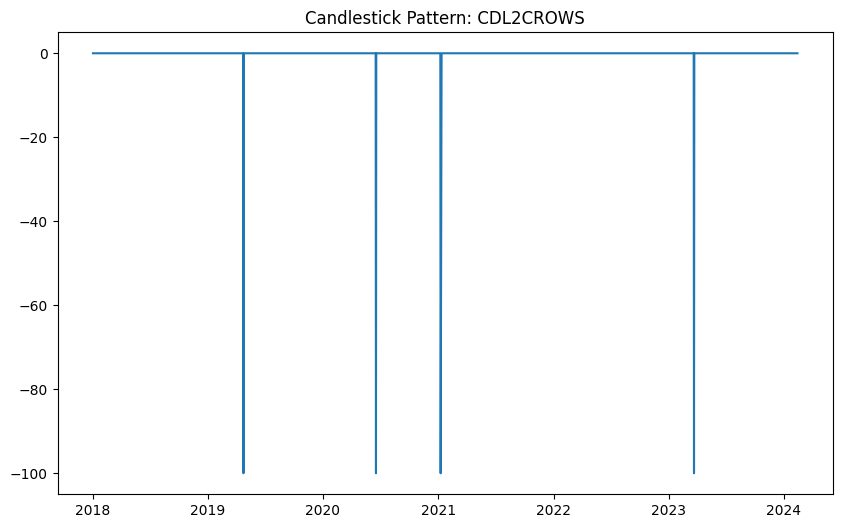

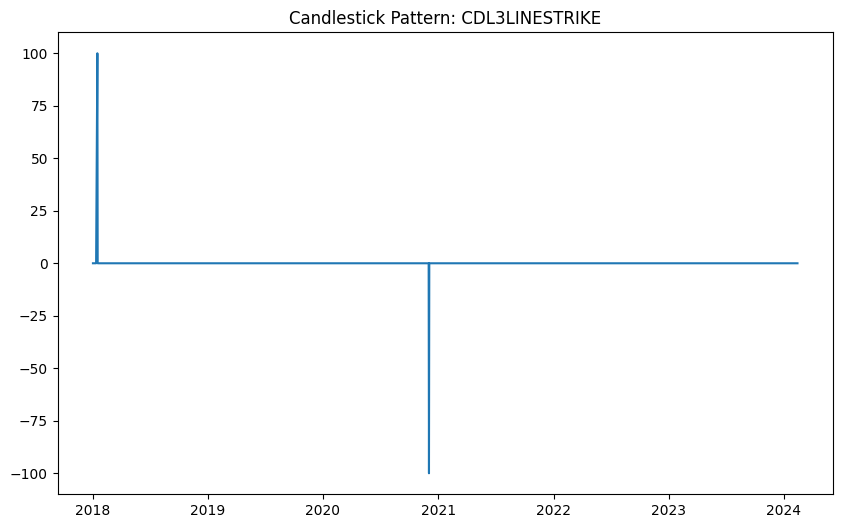

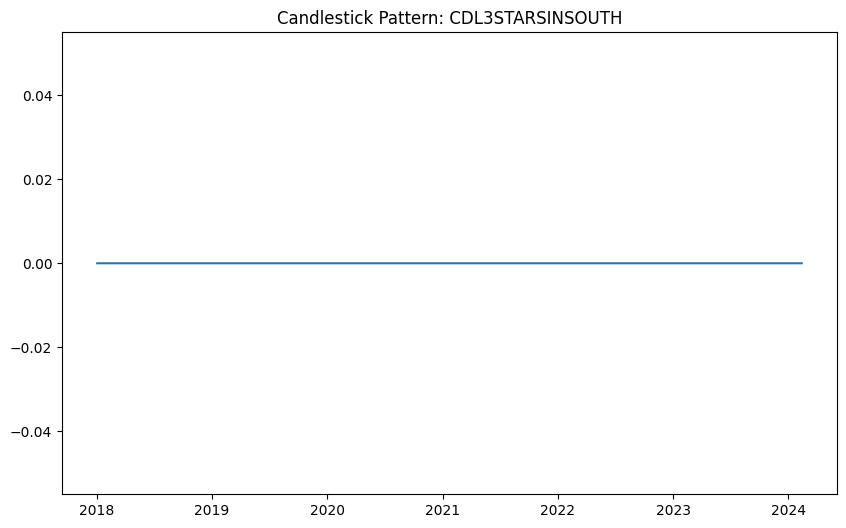

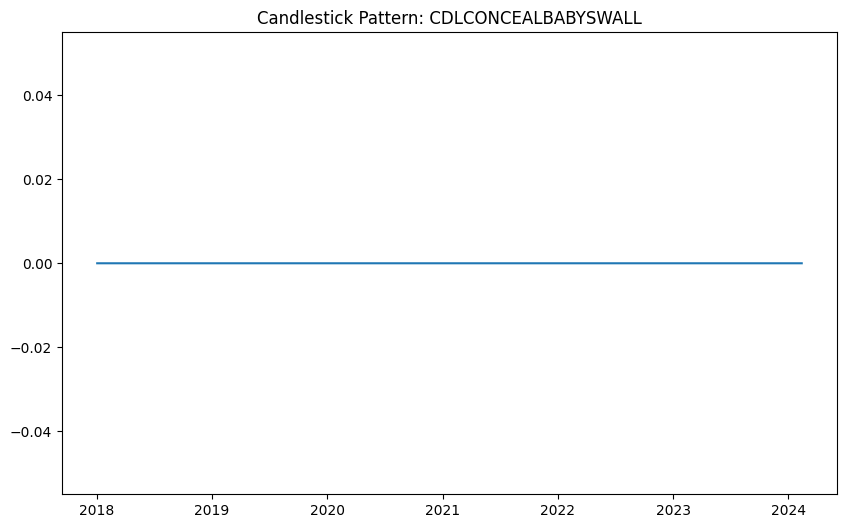

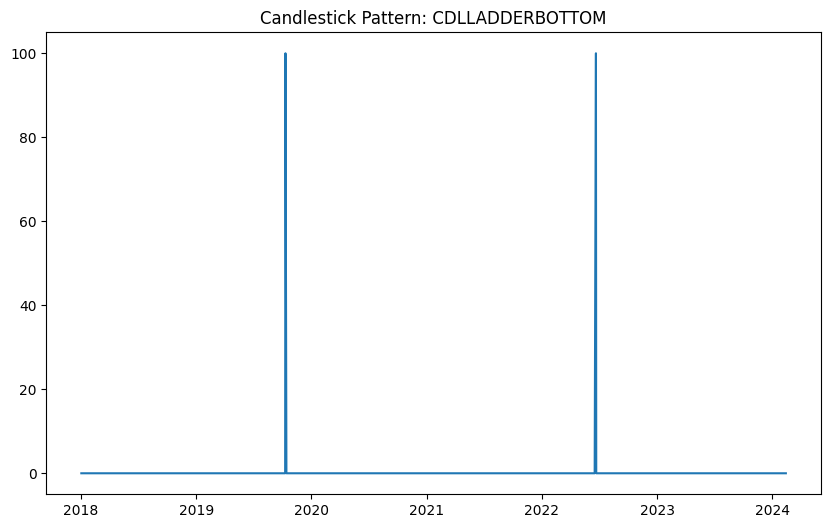

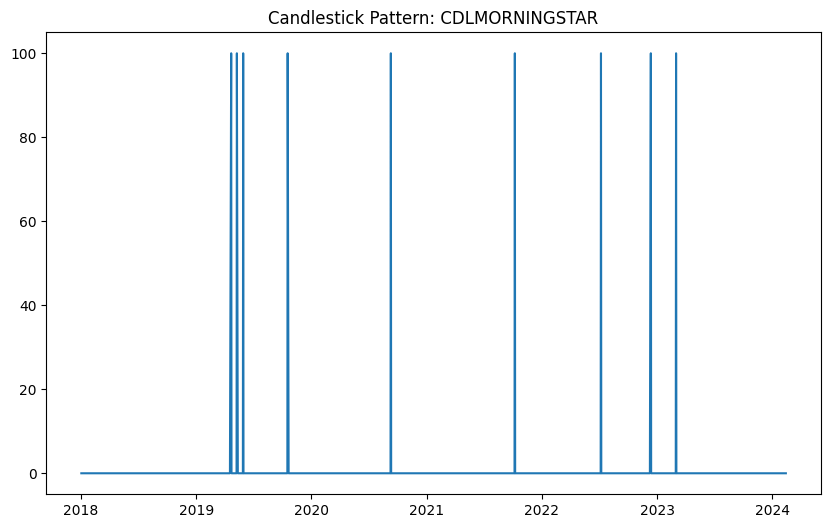

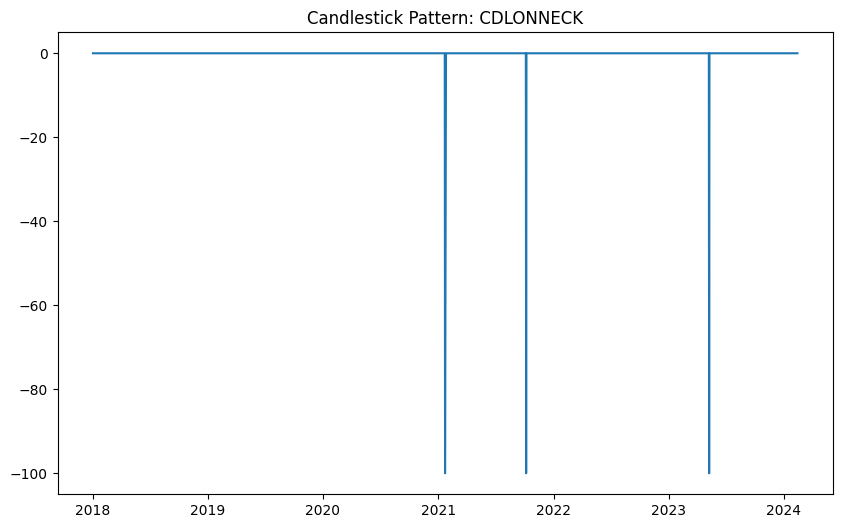

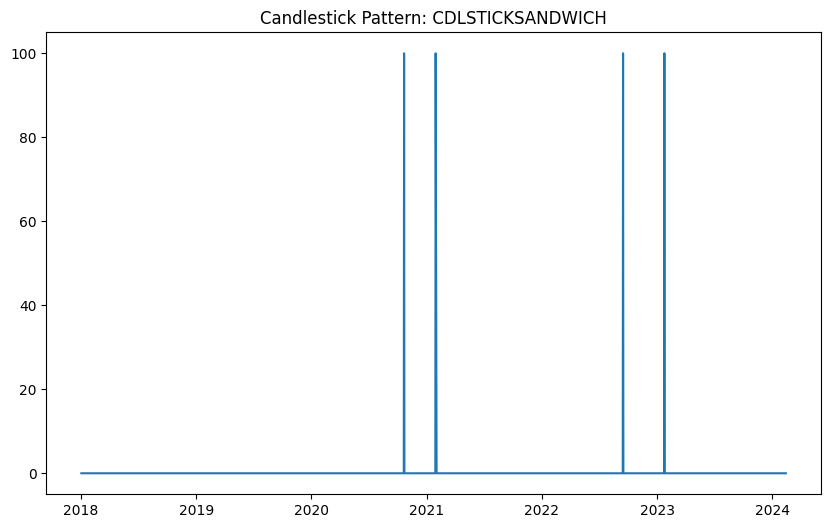

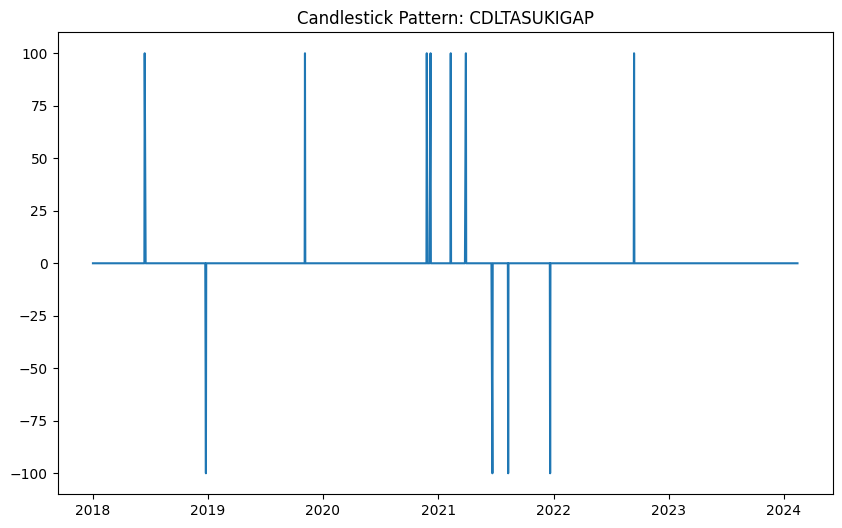

In [93]:

My_ticker = ["WMB"]
# Define candlestick patterns
candlestick_patterns = [
    "CDL2CROWS", "CDL3LINESTRIKE", "CDL3STARSINSOUTH", "CDLCONCEALBABYSWALL",
    "CDLLADDERBOTTOM", "CDLMORNINGSTAR", "CDLONNECK",
    "CDLSTICKSANDWICH", "CDLTASUKIGAP"
]

pattern_data = {}

# Iterate over tickers
for ticker in My_ticker:
    data = yf.download(ticker,  start="2018-01-01", end="2024-02-14")

    # Identify candlestick patterns for each pattern in the list
    for pattern in candlestick_patterns:
        pattern_values = getattr(talib, pattern)(data['Open'], data['High'], data['Low'], data['Close'])
        pattern_data[f"{pattern}_{ticker}"] = pattern_values

# Plotting candlestick patterns
for pattern in candlestick_patterns:
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"Candlestick Pattern: {pattern}")

    # Plot each ticker's pattern data
    for ticker in My_ticker:
        pattern_values = pattern_data.get(f"{pattern}_{ticker}", None)
        if pattern_values is not None:
            ax.plot(data.index, pattern_values, label=ticker)

    # ax.legend()
    # plt.xlabel("Date")
    # plt.ylabel("Pattern Value")
    # plt.grid(True)
    # plt.show()


In [94]:

My_ticker = ["WMB"]
#My_ticker = ["AAPL", "MSFT"]

candlestick_patterns = [
    "CDL2CROWS", "CDL3LINESTRIKE","CDL3STARSINSOUTH", "CDLCONCEALBABYSWALL",
    "CDLLADDERBOTTOM", "CDLMORNINGSTAR", "CDLONNECK",
    "CDLSTICKSANDWICH","CDLTASUKIGAP"]

combined_normalized_df = pd.DataFrame()
normalized_dfs = []
pattern_data = {}
stock_pattern_data = {}

for ticker in My_ticker:
    for pattern in candlestick_patterns:
        data = yf.download(ticker,  start="2018-01-01", end="2024-02-14")
        pattern_values = getattr(talib, pattern)(data['Open'], data['High'], data['Low'], data['Close'])
        normalized_pattern_values = pattern_values
        col_name = f"Normalized_{pattern}_{ticker}"
        # Store the normalized pattern values in the dictionary
        if col_name not in pattern_data:
            pattern_data[col_name] = normalized_pattern_values
        else:
            pattern_data[col_name] = pd.concat([pattern_data[col_name], normalized_pattern_values], axis=1)
        pattern_df = pd.DataFrame(pattern_data, index=data.index)
        pattern_df = pattern_df/100

    ## Calculate Aroon Oscillator
    aroon_oscillator = talib.AROONOSC(data['High'], data['Low'], timeperiod=14)
    my_trix = talib.TRIX(data['Close'], timeperiod=14)
    cci = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
    adx = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
    macd,_,_ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    _, middle_band, _ = talib.BBANDS(close, timeperiod=14, nbdevup=2, nbdevdn=2)


    trix_df = pd.DataFrame(my_trix, index=data.index, columns=[f"Trix_{ticker}"])
    aroon_oscillator_df = (pd.DataFrame(aroon_oscillator, index=data.index, columns=[f"AROONOSC_{ticker}"]))/100
    cci_df = pd.DataFrame(cci, index=data.index, columns=[f"CCI_{ticker}"])
    adx_df = pd.DataFrame(adx, index=data.index, columns=[f"ADX_{ticker}"])
    macd_df = pd.DataFrame(macd, index=data.index, columns=[f"MACD_{ticker}"])

    normalized_cci_values= normalize_min_max(cci_df[f"CCI_{ticker}"])
    normalized_adx_values = normalize_min_max(adx_df[f"ADX_{ticker}"])

    combined_normalized_df = pd.concat([combined_normalized_df,
                                        aroon_oscillator_df,
                                        pattern_df,
                                        trix_df,
                                        normalized_cci_values,
                                        normalized_adx_values,
                                        macd_df,], axis=1)

combined_normalized_df.dropna(inplace=True)
combined_normalized_df = combined_normalized_df.loc[:, ~combined_normalized_df.columns.duplicated()]    # combined_normalized_df = combined__normalized_df_shift
combined_normalized_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AROONOSC_WMB,Normalized_CDL2CROWS_WMB,Normalized_CDL3LINESTRIKE_WMB,Normalized_CDL3STARSINSOUTH_WMB,Normalized_CDLCONCEALBABYSWALL_WMB,Normalized_CDLLADDERBOTTOM_WMB,Normalized_CDLMORNINGSTAR_WMB,Normalized_CDLONNECK_WMB,Normalized_CDLSTICKSANDWICH_WMB,Normalized_CDLTASUKIGAP_WMB,Trix_WMB,CCI_WMB,ADX_WMB,MACD_WMB
2018-03-01,-0.642857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.498702,0.269583,0.621546,-1.036610
2018-03-02,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.507841,0.260750,0.657554,-1.084581
2018-03-05,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.516695,0.347778,0.676009,-1.099435
2018-03-06,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.520841,0.405611,0.688806,-1.067433
2018-03-07,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.521889,0.409118,0.701995,-1.043757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-07,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.067817,0.495995,0.093105,-0.141069
2024-02-08,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.068536,0.416341,0.096892,-0.171133
2024-02-09,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.071038,0.402146,0.102449,-0.193534
2024-02-12,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070877,0.500954,0.085994,-0.167399


In [95]:
combined__normalized_df_shift = combined_normalized_df.shift(1)
combined__normalized_df_shift.dropna(inplace=True)
#combined__normalized_df_shift

In [96]:
combined__normalized_df_shift

,AROONOSC_WMB,Normalized_CDL2CROWS_WMB,Normalized_CDL3LINESTRIKE_WMB,Normalized_CDL3STARSINSOUTH_WMB,Normalized_CDLCONCEALBABYSWALL_WMB,Normalized_CDLLADDERBOTTOM_WMB,Normalized_CDLMORNINGSTAR_WMB,Normalized_CDLONNECK_WMB,Normalized_CDLSTICKSANDWICH_WMB,Normalized_CDLTASUKIGAP_WMB,Trix_WMB,CCI_WMB,ADX_WMB,MACD_WMB
2018-03-02,-0.642857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.498702,0.269583,0.621546,-1.036610
2018-03-05,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.507841,0.260750,0.657554,-1.084581
2018-03-06,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.516695,0.347778,0.676009,-1.099435
2018-03-07,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.520841,0.405611,0.688806,-1.067433
2018-03-08,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.521889,0.409118,0.701995,-1.043757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-07,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070026,0.530692,0.100743,-0.126100
2024-02-08,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.067817,0.495995,0.093105,-0.141069
2024-02-09,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.068536,0.416341,0.096892,-0.171133
2024-02-12,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.071038,0.402146,0.102449,-0.193534


# Transformer model

In [97]:
class PositionalEncoding  (nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # print('position =',position.shape)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # print('div_term =',div_term.shape)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # print(pe.shape)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print('shape of x =',x.shape)
        PE = self.pe[:x.size(0), :]
        # print('shape of pe',PE.shape)
        # print('x + self.pe[:x.size(0), :] =',(x + self.pe[:x.size(0), :]).shape)
        return x + self.pe[:x.size(0), :]



In [98]:
class TransAm(nn.Module):
    def __init__(self, feature_size=64, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('src =',src.shape)
        output = self.transformer_encoder(src,self.src_mask)
        # print('encoder_output =',output.shape)
        output = self.decoder(output)
        # print('decoder_output =',output.shape)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [99]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        # print(train_seq)
        train_label = input_data[i + output_window:i + tw + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [100]:
def get_data_multi(data, split):
    num_features = data.shape[1]  # Get the number of features
    train_split = int(split[0] * len(data))
    val_split = int((split[0] + split[1]) * len(data))

    train_data, val_data, test_data = [], [], []
    for i in range(num_features):
        train_data.append(data[:train_split, i])
        val_data.append(data[train_split:val_split, i])
        test_data.append(data[val_split:, i])

    train_data = np.stack(train_data, axis=1)
    val_data = np.stack(val_data, axis=1)
    test_data = np.stack(test_data, axis=1)

    train_sequence = create_inout_sequences(train_data, input_window)
    val_sequence = create_inout_sequences(val_data, input_window)
    test_sequence = create_inout_sequences(test_data, input_window)

    train_sequence = train_sequence[:-output_window]
    val_sequence = val_sequence[:-output_window]
    test_sequence = test_sequence[:-output_window]

    return (
        torch.FloatTensor(train_sequence).to(device),
        torch.FloatTensor(val_sequence).to(device),
        torch.FloatTensor(test_sequence).to(device)
    )


In [101]:

def get_data(data, split):
    series = data[:, 0]  # the first feature
    vol = data[:, 1]     # the second feature
    f3 = data[:, 2]      # the third feature

    train_split = int(split[0] * len(series))
    val_split = int((split[0] + split[1]) * len(series))

    train_series, val_series, test_series = series[:train_split], series[train_split:val_split], series[val_split:]
    train_vol, val_vol, test_vol = vol[:train_split], vol[train_split:val_split], vol[val_split:]
    train_f3, val_f3, test_f3 = f3[:train_split], f3[train_split:val_split], f3[val_split:]

    train_data = np.stack([train_series, train_vol, train_f3], axis=1)
    val_data = np.stack([val_series, val_vol, val_f3], axis=1)
    test_data = np.stack([test_series, test_vol, test_f3], axis=1)

    train_sequence = create_inout_sequences(train_data, input_window)
    val_sequence = create_inout_sequences(val_data, input_window)
    test_sequence = create_inout_sequences(test_data, input_window)

    train_sequence = train_sequence[:-output_window]
    val_sequence = val_sequence[:-output_window]
    test_sequence = test_sequence[:-output_window]

    return (
        torch.FloatTensor(train_sequence).to(device),
        torch.FloatTensor(val_sequence).to(device),
        torch.FloatTensor(test_sequence).to(device)
    )


In [102]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    # print('batch_size_getbatch =',batch_size)
    # print('seq_len =',seq_len)
    # print('i =',i)
    # print('source =',source.shape)
    data = source[i:i+seq_len]
    # print("data =",data.shape)

    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, -1))  ###
    input = input.reshape(14, seq_len, 10, 1)  #torch.Size([14, 64, 10, 1])
    input = input.squeeze(-1)
    input = input.permute(2, 1, 0)
    input = input.reshape(140, seq_len, 1)  # 10*14
    # print('input.shape =',input.shape)

    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, -1))  ###
    target = target.reshape(14, seq_len, 10, 1)
    target = target.squeeze(-1)
    target = target.permute(2, 1, 0)
    target = target.reshape(140, seq_len, 1)
    # print('target =',target.shape)
    return input, target



In [103]:
def train(train_data):
    model.train()
    total_loss = 0.
    start_time = time.time()

    if len(train_data) == 0:
        print("Error: Empty training data.")
        return

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        targets = data.permute(0,1,2)

        # print(f'{data.shape = }')
        # print(f'{targets.shape = }')
        # print('\n')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5) if len(train_data) > 0 and batch_size > 0 else 1
        if log_interval != 0 and batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()


In [141]:
def Mytrain(train_data, loss_list):
    model.train()
    total_loss = 0.
    start_time = time.time()

    if len(train_data) == 0:
        print("Error: Empty training data.")
        return

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        targets = data.permute(0, 1, 2)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5) if len(train_data) > 0 and batch_size > 0 else 1
        if log_interval != 0 and batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()
        if batch == len(train_data) // batch_size - 1:  # Check if this is the last batch of the epoch
            loss_list.append(cur_loss)  # Append the current loss to the list


In [105]:
def evaluate(eval_model, data_source):
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    arr_loss = []
    eval_batch_size = 64  # Adjust batch size according to your preference
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            loss = criterion(output, targets)
            total_loss += len(data[0]) * loss.cpu().item()
    return total_loss / len(data_source)

In [145]:
def Myevaluate(eval_model, data_source, arr_loss):
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 64  # Adjust batch size according to your preference
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            loss = criterion(output, targets)
            total_loss += len(data[0]) * loss.cpu().item()
    arr_loss.append(total_loss / len(data_source))
    return total_loss / len(data_source)


In [107]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()
    return seq

In [108]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

# Parameter before training

In [109]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
Indi_WMB = combined__normalized_df_shift.values
print(Indi_WMB.shape)

(1498, 14)


In [111]:
#### Try 3 indicators ####
Trix_WMB = pd.DataFrame(combined__normalized_df_shift['Trix_WMB']).values
MACD_WMB = pd.DataFrame(combined__normalized_df_shift['MACD_WMB']).values
CCI_WMB =  pd.DataFrame(combined__normalized_df_shift['CCI_WMB']).values

In [112]:
Trix_WMB.shape

(1498, 1)

In [113]:
my_dataset = np.stack([Trix_WMB,MACD_WMB,CCI_WMB]).T
my_dataset = np.squeeze(my_dataset, axis=0)
my_dataset.shape

(1498, 3)

In [114]:
my_dataset

array([[-0.49870155, -1.03660957,  0.2695826 ],
       [-0.50784061, -1.08458093,  0.26075035],
       [-0.51669518, -1.09943512,  0.34777754],
       ...,
       [-0.06853583, -0.17113262,  0.41634085],
       [-0.07103848, -0.19353435,  0.40214619],
       [-0.07087694, -0.16739852,  0.50095398]])

In [115]:
my_dataset.shape

(1498, 3)

In [116]:

# split = [0.6, 0.2, 0.2]
# train_data, val_data ,test_data= get_data(my_dataset, split) # 60% train, 20% test split,20% valid
# print('train_data =',train_data.shape)
# print('val_data =',val_data.shape)
# print('test_data =',test_data.shape)
# print(train_data)
# print(val_data)
# print(test_data)



In [117]:
split = [0.6, 0.2, 0.2]
train_data, val_data ,test_data= get_data_multi(Indi_WMB, split) # 60% train, 20% test ,20% valid
print('train_data =',train_data.shape)
print('val_data =',val_data.shape)
print('test_data =',test_data.shape)
# print(train_data)
# print(val_data)
# print(test_data)

train_data = torch.Size([887, 2, 10, 14])
val_data = torch.Size([289, 2, 10, 14])
test_data = torch.Size([289, 2, 10, 14])


In [118]:
# train_data

# Training

In [153]:
model = TransAm().to(device)

In [154]:
criterion = nn.MSELoss()  # Loss function
lr = 0.00005  # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
loss_list = []
loss_valid = []
epochs = 30  # Number of epochs #

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    Mytrain(train_data, loss_list)
    val_loss = Myevaluate(model, val_data,loss_valid)
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
    print('-' * 80)

    scheduler.step()


| epoch   1 |     2/   13 batches | lr 0.0000500000 | 3180.30 ms | loss 0.3235666
| epoch   1 |     4/   13 batches | lr 0.0000500000 | 1047.95 ms | loss 0.1730622
| epoch   1 |     6/   13 batches | lr 0.0000500000 | 1048.88 ms | loss 0.1556953
| epoch   1 |     8/   13 batches | lr 0.0000500000 | 1104.56 ms | loss 0.2252900
| epoch   1 |    10/   13 batches | lr 0.0000500000 | 1310.48 ms | loss 0.1155894
| epoch   1 |    12/   13 batches | lr 0.0000500000 | 1411.36 ms | loss 0.1183482
--------------------------------------------------------------------------------
| end of epoch   1 | time: 20.20s | valid loss: 0.1285676
--------------------------------------------------------------------------------
| epoch   2 |     2/   13 batches | lr 0.0000451250 | 1571.74 ms | loss 0.2051301
| epoch   2 |     4/   13 batches | lr 0.0000451250 | 1078.99 ms | loss 0.1065671
| epoch   2 |     6/   13 batches | lr 0.0000451250 | 1558.07 ms | loss 0.1056081
| epoch   2 |     8/   13 batches | lr 0.0

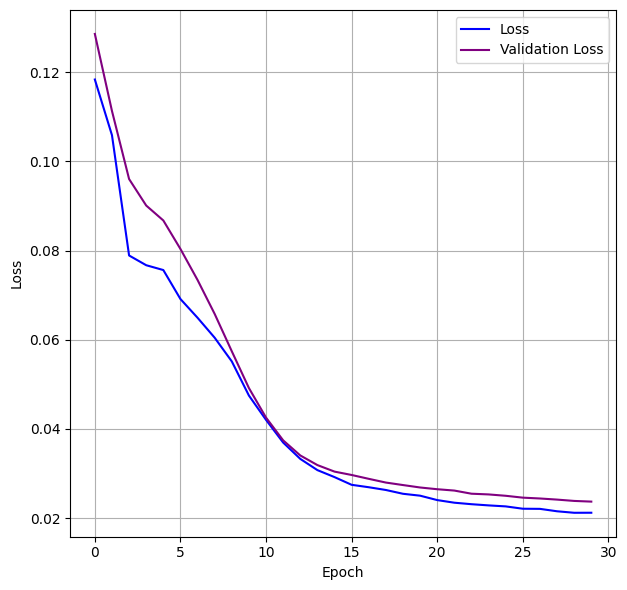

In [155]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Loss', color='blue')   ## Use the last loss
plt.plot(loss_valid, label='Validation Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [178]:
def evaluate_test(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 64 #1000
    output_test = []
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            # predicted_values_list = output.tolist()
            # print(predicted_values_list)
            print(f'{data.shape = }, {targets.shape = }, {output.shape = }')
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()

            output_test.append(output) # output_test.append(predicted_values_list)
    return output_test

In [179]:
output_test = evaluate_test(model,test_data)

data.shape = torch.Size([140, 64, 1]), targets.shape = torch.Size([140, 64, 1]), output.shape = torch.Size([140, 64, 1])
data.shape = torch.Size([140, 64, 1]), targets.shape = torch.Size([140, 64, 1]), output.shape = torch.Size([140, 64, 1])
data.shape = torch.Size([140, 64, 1]), targets.shape = torch.Size([140, 64, 1]), output.shape = torch.Size([140, 64, 1])
data.shape = torch.Size([140, 64, 1]), targets.shape = torch.Size([140, 64, 1]), output.shape = torch.Size([140, 64, 1])
data.shape = torch.Size([140, 32, 1]), targets.shape = torch.Size([140, 32, 1]), output.shape = torch.Size([140, 32, 1])


In [189]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [187]:
Ty_0 = output_test[0].reshape(10, 64, 14)

print(Ty_0.shape)

torch.Size([10, 64, 14])


tensor([[[ 3.4088e-01, -7.2980e-01,  2.1831e-02,  ..., -5.9967e-02,
           2.0771e-01,  1.6832e-01],
         [ 3.4088e-01, -3.1436e-01,  2.1831e-02,  ..., -9.7155e-02,
           1.6302e-01,  1.8693e-01],
         [ 3.4088e-01, -1.4506e-01,  2.1831e-02,  ..., -6.6224e-02,
           2.0996e-01,  1.8214e-01],
         ...,
         [-1.4709e-01, -9.8140e-01, -5.9210e-02,  ..., -1.7068e-01,
           1.7920e-02,  1.0798e-01],
         [-9.7727e-01, -2.6869e-01,  7.4564e-06,  ..., -1.4216e-01,
           2.6035e-02,  1.9194e-02],
         [-1.7589e-01, -8.3279e-01, -3.6421e-02,  ..., -1.8162e-01,
          -4.2558e-02,  1.3683e-01]],

        [[ 6.9899e-03, -2.2327e-02,  2.2426e-02,  ...,  6.0667e-02,
           8.9739e-01, -1.1060e-01],
         [ 2.9589e-02, -4.1682e-02, -1.6284e-02,  ...,  5.9975e-02,
           4.8099e-02, -1.8100e-01],
         [ 1.4485e-03,  1.0617e-01,  7.8655e-02,  ...,  4.3858e-02,
           4.5662e-01, -1.9507e-01],
         ...,
         [-1.1115e-01, -6

In [168]:
len(output_test[0])

140

In [ ]:
print(len(output_test))
test1 = output_test[0]
print(len(output_test[0]))
print(output_test[0])
# print(output_test[1].shape)
# print(output_test[2].shape)

3
30
[[[0.3628078103065491], [0.8144420385360718], [0.749906063079834], [0.384998083114624], [0.861126184463501], [0.7578793168067932], [0.39959073066711426], [0.841286301612854], [0.6699056625366211], [0.4050147533416748], [0.7960245013237], [0.60136878490448], [0.40572983026504517], [0.7714294791221619], [0.6108100414276123], [0.40228453278541565], [0.742996335029602], [0.6080105900764465], [0.39735180139541626], [0.7309309244155884], [0.6249921321868896], [0.3925429582595825], [0.730154812335968], [0.6640790700912476], [0.3878939151763916], [0.729486882686615], [0.6998592615127563], [0.38279497623443604], [0.7232208847999573], [0.6607182621955872], [0.3773624897003174], [0.7170433402061462], [0.6660447120666504], [0.37093257904052734], [0.7040121555328369], [0.6692301034927368], [0.36336004734039307], [0.6875892877578735], [0.6317288875579834], [0.35734742879867554], [0.6930762529373169], [0.7176458835601807], [0.349257230758667], [0.6679483652114868], [0.6364646553993225], [0.33648

In [ ]:
print(output_test[1])

tensor([[[-0.0975],
         [-0.0383],
         [ 0.7082],
         ...,
         [ 0.2721],
         [ 0.6046],
         [ 0.1007]],

        [[-0.0146],
         [ 0.4148],
         [ 0.4065],
         ...,
         [ 0.2321],
         [ 0.3245],
         [-0.0270]],

        [[ 0.0854],
         [ 0.1728],
         [ 0.2098],
         ...,
         [ 0.0768],
         [ 0.1435],
         [ 0.1096]],

        ...,

        [[ 0.1013],
         [ 0.2791],
         [ 0.4827],
         ...,
         [ 0.1340],
         [ 0.5457],
         [ 0.0338]],

        [[ 0.1559],
         [ 0.4813],
         [ 0.1759],
         ...,
         [ 0.2236],
         [-0.0029],
         [-0.0488]],

        [[ 0.2312],
         [ 0.1314],
         [-0.0421],
         ...,
         [ 0.0483],
         [-0.2048],
         [ 0.1837]]])


In [ ]:
print(output_test[0])
output_reshape = np.array(output_test)
output_reshape = output_test.reshape(10, 64, 3)

tensor([[[0.3628],
         [0.8144],
         [0.7499],
         ...,
         [0.6444],
         [0.8185],
         [0.2971]],

        [[0.5258],
         [0.7420],
         [0.5226],
         ...,
         [0.4195],
         [0.4976],
         [0.0080]],

        [[0.3815],
         [0.5576],
         [0.2849],
         ...,
         [0.1840],
         [0.2179],
         [0.5373]],

        ...,

        [[0.3707],
         [0.8130],
         [0.5405],
         ...,
         [0.4159],
         [0.4524],
         [0.3091]],

        [[0.3675],
         [0.6050],
         [0.2856],
         ...,
         [0.3737],
         [0.1458],
         [0.1096]],

        [[0.3623],
         [0.2610],
         [0.1035],
         ...,
         [0.2597],
         [0.3219],
         [0.4569]]])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 30) + inhomogeneous part.

In [ ]:
test_result, truth = forecast_seq(model, val_data)

0.19338107109069824 sec


In [ ]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()